Modelo de clasificación de imágenes con transferencia de aprendizaje
====================================================================

## Introducción

La clasificación de objetos es la tarea por la cual un modelo de aprendizaje automático asigna una o varias etiquetas a diferentes imágenes dependiendo del contenido de la misma. Esta tarea se volvió muy popular en 2012 en el contexto de aprendizaje automático ya que fué la primera tarea en alcanzar una performance sustancialmente mayor que con técnicas clásicas. En esta ocación utilizaremos un modelo basado en Transfer Learning el cual operará como extractor de features para nuestro modelo.

### Preparación del ambiente

Intalamos las librerias necesarias

In [1]:
!wget https://raw.githubusercontent.com/santiagxf/M72109/master/docs/vision/tasks/classification/code/cnn_class_transfer_learning.txt \
    --quiet --no-clobber
!pip install -r cnn_class_transfer_learning.txt --quiet

### Sobre el conjunto de datos de este ejemplo

Para ejemplificar esta técnica utilizaremos un conjunto de datos muy popular llamado CIFAR-10. CIFAR-10 es un conjunto de datos que consiste en 60.000 imagenes a color de 32x32 agrupadas en 10 clases, con 6000 imagenes cada una. Hay alrededor de 50000 imagenes para entrenamiento y 10000 para testing.

Las categorias son:
 - airplane
 - automobile
 - bird
 - cat
 - deer
 - dog
 - frog
 - horse
 - ship
 - truck

Podemos cargar este conjunto de datos facilmente utilizando `tensorflow-datasets`:

In [2]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_datasets as tfds

ds, info = tfds.load('cifar10', split='train', shuffle_files=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incomplete1174FU/cifar10-train.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incomplete1174FU/cifar10-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [3]:
print("Numero de clases: ", info.features["label"].num_classes)
print("Clases disponibles: ", info.features["label"].names)

Numero de clases:  10
Clases disponibles:  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Veamos algunos ejemplos:

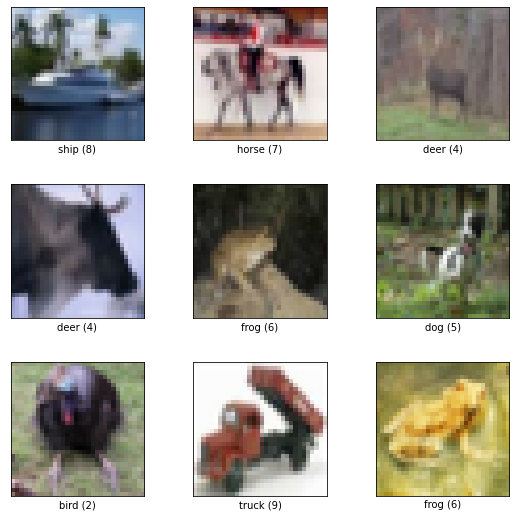

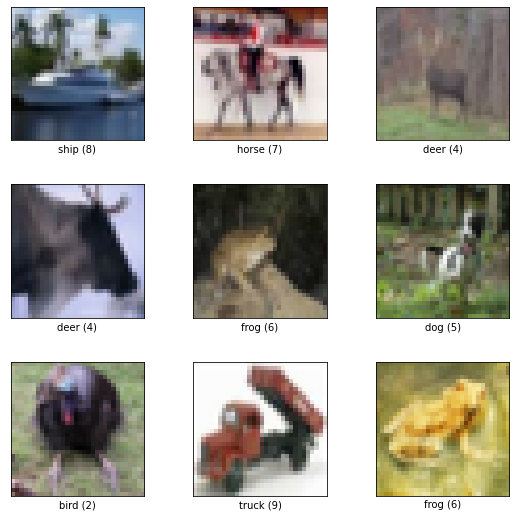

In [4]:
tfds.show_examples(ds, info)

## Utilizando transferencia de aprendizaje en nuestro modelo

### ¿Qué es TensorFlow Hub?

Un concepto que es esencial en el desarrollo de software es la idea de reutilizar el código que está disponible a través de librerías. Las librerías hacen que el desarrollo sea más rápido y generan más eficiencia. Para los cientificos de datos que trabajan en visión artificial, entrenar arquitecturas de redes neuronales complejas desde cero resulta altamente complejo. TensorFlow Hub es una biblioteca que permite publicar y reutilizar componentes de aprendizaje automático prediseñados. Con TF.Hub, resulta sencillo volver a entrenar la capa superior de un modelo previamente entrenado para reconocer las clases en un nuevo conjunto de datos. TensorFlow Hub también distribuye modelos sin la capa de clasificación. Estos se pueden utilizar para realizar fácilmente el aprendizaje por transferencia. Puede descargar cualquier [modelo para imágenes compatible con Tensorflow 2 de tfhub.dev](https://tfhub.dev/s?module-type=image-feature-vector&q=tf2). La única condición es asegurarse de que la forma de las características de la imagen en nuestro conjunto de datos preparado coincida con la forma de entrada esperada del modelo que desea reutilizar.

### Antes de comenzar

Antes de comenzar necesitaremos verificar que tenemos el runtime correcto en nuestro ambiente. Esta tarea se beneficiará mucho de una GPU.

In [5]:
import tensorflow as tf
print("GPUs disponibles: ", len(tf.config.experimental.list_physical_devices('GPU')))

GPUs disponibles:  1


Adicionalmente, configuraremos nuestro conjunto de datos para una tarea supervisada. Esto lo hacemos especificando el parametro *as_supervised=True* lo cual nos da la posibilidad de acceder a las anotaciones del conjunto de datos.

In [12]:
(training_set, validation_set) = tfds.load('cifar10', split=['train[:10%]', 'test[:10%]'], as_supervised=True)

### Ajustando el tamaño de nuestras imagenes

ResNet es un modelo que se entrenó utilizando imagenes de tamaño 224x224. Sin embargo, nuestras imagenes podrían no tener este tamaño e incluso podrían no tener el mismo tamañao. ¿Como hacemos para ajustar el tamaño? Utilizaremos una técnica similar a cuando ajustamos la longitud de las secuencias en NLP. Padding. Padding agregará ceros en en la imagen hasta completar el tamaño especificado: 

<img src="https://th.bing.com/th/id/OIP.8D8BXN3aHLCyTNTE2GssmQAAAA?pid=Api&rs=1" />

En TensorFlow, esto lo podemos realizar utilizando el metodo *padded_batch* el cual agrupa las imagenes en batches para entrenamiento y al mismo tiempo ajusta el tamaño de los tensores al necesitado:

In [13]:
BATCH_SIZE=64
EPOCHS = 3

In [17]:
training_set_batch = training_set.padded_batch(batch_size=BATCH_SIZE, padded_shapes=([224, 224, 3], [])).cache().repeat()
validation_set_batch = validation_set.padded_batch(batch_size=BATCH_SIZE, padded_shapes=([224, 224, 3], [])).cache().repeat()
train_size = info.splits['train[:10%]'].num_examples
test_size = info.splits['test[:10%]'].num_examples

> Note que en este ejemplo estaremos utilizando el 10% del conjunto de entrenamiento para reducir la complejidad del modelo.

### Construimos nuestro modelo basado en ResNet50

Construiremos nuestro modelo basado en ResNet50. ResNet-50 es una CNN de 50 capas de profundidad que utiliza el concepto de skip-connection, de una forma similar a la que se utiliza por el sistema de visión humano. Esta implementación le permite a la red reutilizar las activaciones de capas anteriores y asi no solo mapear conceptos que se aprendieron en otra jerarquia de la red sino que también evitar el problema de desaparición de los gradientes.

In [19]:
import tensorflow_hub as hub

def buildModel():
    model = keras.models.Sequential([
        hub.KerasLayer("https://tfhub.dev/google/imagenet/resnet_v1_50/feature_vector/5", trainable=False, input_shape=(224,224,3)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

    model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
    return model

Instanciamos nuestro modelo y verificamos su arquitectura

In [20]:
model = buildModel()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 2048)              23561152  
_________________________________________________________________
dense_2 (Dense)              (None, 128)               262272    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
Total params: 23,824,714
Trainable params: 263,562
Non-trainable params: 23,561,152
_________________________________________________________________


Comenzamos el entrenamiento

In [21]:
history = model.fit(training_set_batch, 
                    epochs=EPOCHS,
                    steps_per_epoch=train_size,
                    validation_data=validation_set_batch,
                    validation_steps=test_size)

Epoch 1/3
5000/5000 [==============================] - 1704s 340ms/step - loss: 1.9665 - accuracy: 0.4061 - val_loss: 1.6422 - val_accuracy: 0.4133
Epoch 2/3
5000/5000 [==============================] - 1696s 339ms/step - loss: 1.3295 - accuracy: 0.5253 - val_loss: 1.7559 - val_accuracy: 0.4252
Epoch 3/3
5000/5000 [==============================] - 1715s 343ms/step - loss: 1.2300 - accuracy: 0.5527 - val_loss: 1.6683 - val_accuracy: 0.4601


> Dado que estamos utilizando un objeto de tipo `tf.Dataset` como argumento de `validation_data` de `Model.fit`, Keras no sabe por cuantos etapas hay que validar. Por este motivo el argumento `validation_steps` fue configurado.

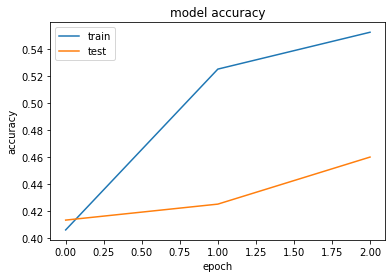

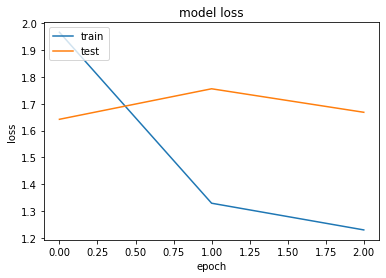

In [22]:
import matplotlib.pyplot as plt

def plot_history(history):
  # summarize history for accuracy
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

plot_history(history)